<a href="https://colab.research.google.com/github/tgchen321/NLP_EmbedFintechJournal/blob/main/3.%20Research%20data/FreeGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# import necessary libraries
from google.colab import drive
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import nltk
import torch
import torchtext
import time
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/summerProject/
import myNLPTool, pickle, math

GDpath = '/content/drive/MyDrive/Colab Notebooks/summerProject/'

!nvidia-smi

AttributeError: ignored

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
with open("dataList.pkl", "rb") as pkl:
		dataset = pickle.load(pkl)

targetSents, targetWords, wholeFileInWords = myNLPTool.Tokenise(dataset[0]["fullText"])
_, _, queryWords = myNLPTool.Tokenise(dataset[0]["citeSent"])

def Evaluation(result):
	# print(result)
	print("# RESULTS: ")
	result.sort(reverse = True)
	print("Average similarity(cosine sim.): " + str(sum(result)/len(result)))
	print("Maximum similarity(cosine sim.): " + str(result[0]))
	print("Minimum similarity(cosine sim.): " + str(result[-1]))
	if len(result) > 10:
		top10 = math.ceil(len(result)/10)
		print("Top 10% average similarity(cosine sim.): " + str(sum(result[:top10])/top10))
		_, ax = plt.subplots(figsize =(10, 7))
		ax.hist(result)
		plt.show()
	print()

# USE

In [ ]:
# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Sentences for which you want to create embeddings,
# passed as an array in embed()
embeddings = embed([dataset[0]["citeSent"]] + targetSents)

# Printing embeddings of each sentence
# print(embeddings)

# RESULTS: 
Average similarity(cosine sim.): 0.08126362880811984
Maximum similarity(cosine sim.): 0.4644280970096588
Minimum similarity(cosine sim.): -0.14825300872325897
Top 10% average similarity(cosine sim.): 0.2824981524830773


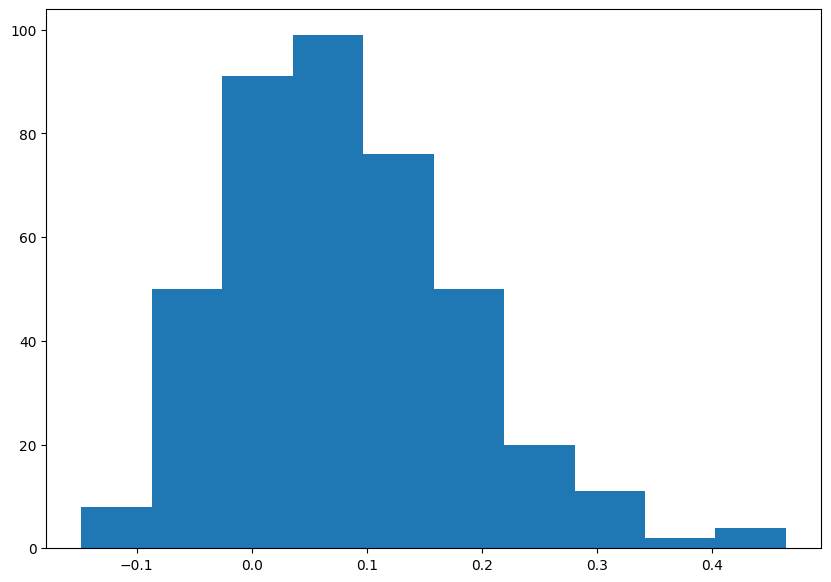

In [ ]:
# sentence
result = []
for i in range(1, len(targetSents)):
    # print(Sentences[i])
    # print(embeddings[i])
    result.append(tf.keras.losses.CosineSimilarity()(embeddings[0], embeddings[i]).numpy() * (-1))

Evaluation(result)

# GloVe

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=100)

100%|█████████▉| 399999/400000 [00:30<00:00, 13051.66it/s]


# RESULTS: 
Average similarity(cosine sim.): tf.Tensor(0.85053694, shape=(), dtype=float32)
Maximum similarity(cosine sim.): tf.Tensor(0.9374974, shape=(), dtype=float32)
Minimum similarity(cosine sim.): tf.Tensor(0.5614605, shape=(), dtype=float32)
Top 10% average similarity(cosine sim.): tf.Tensor(0.9193145, shape=(), dtype=float32)


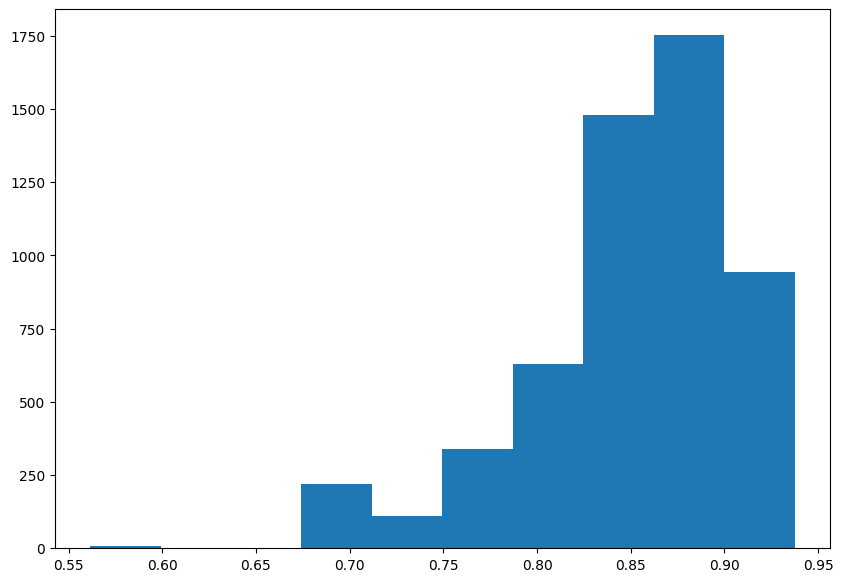

In [ ]:
# sentence
# query embedding
queryWV = torch.zeros(size = [100])
includedWord = 0
for word in queryWords:
    if torch.sum(glove[word]) == 0: continue
    queryWV = torch.add(queryWV, glove[word])
    includedWord += 1
queryWV = queryWV/includedWord

# target embedding & result
result = []
for sentence in targetWords:
    targetWV = torch.zeros(size = [100])
    includedWord = 0
    for word in sentence:
        if torch.sum(glove[word]) == 0: continue
        targetWV = torch.add(targetWV, glove[word])
        includedWord += 1
    targetWV = targetWV/includedWord
    result.append(tf.keras.losses.CosineSimilarity()(queryWV, targetWV).numpy() * (-1))

Evaluation(result)

In [ ]:
# document
# query embedding
queryWV = torch.zeros(size = [100])
includedWord = 0
for word in queryWords:
    if torch.sum(glove[word]) == 0: continue
    queryWV = torch.add(queryWV, glove[word])
    includedWord += 1
queryWV = queryWV/includedWord

# target embedding & result
for word in wholeFileInWords:
    if torch.sum(glove[word]) == 0: continue
    targetWV = torch.add(targetWV, glove[word])
    includedWord += 1
targetWV = targetWV/includedWord
result = tf.keras.losses.CosineSimilarity()(queryWV, targetWV).numpy() * (-1)
result

<tf.Tensor: shape=(), dtype=float32, numpy=0.93592113>

# ELMo

In [4]:
!pip install --upgrade simple_elmo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.1 MB/s eta 0:00:00


In [4]:
import simple_elmo as SE
model = SE.ElmoModel()
model.load("ELMo_eng_model")

/usr/local/lib/python3.10/dist-packages/simple_elmo/model.py:531: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(


'The model is now loaded.'

In [5]:
# sentence
elapsed = []
t = time.time()
queryWV = model.get_elmo_vector_average([dataset[0]["citeSent"]])
elapsed.append(time.time() - t)
targetWVs = model.get_elmo_vector_average(targetSents)

# RESULTS: 
Average similarity(cosine sim.): 0.9262059116433976
Maximum similarity(cosine sim.): 0.9915574561918614
Minimum similarity(cosine sim.): 0.3511946247703288
Top 10% average similarity(cosine sim.): 0.9839693817825195


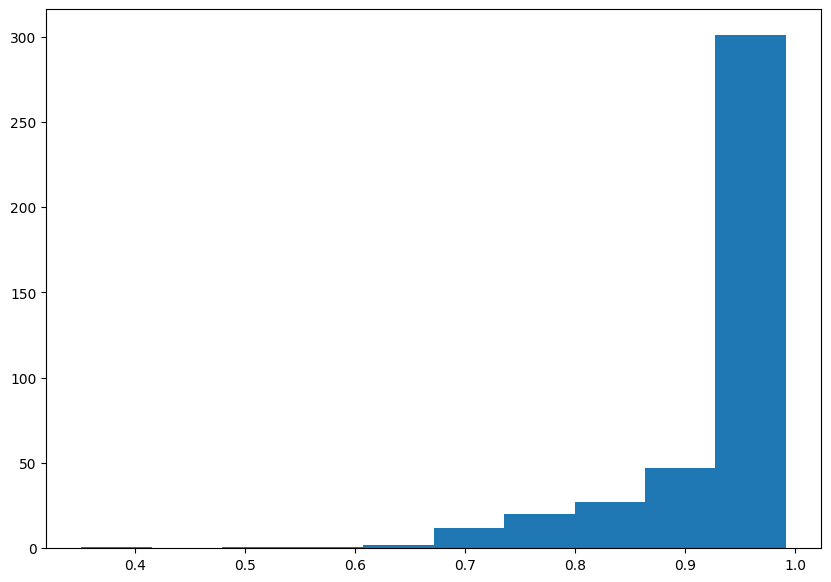

In [24]:
with tf.compat.v1.Session() as sess:
    result = []
    for targetWV in targetWVs:
        result.append((tf.keras.losses.CosineSimilarity()(queryWV[0], targetWV) * (-1)).eval())
Evaluation(result)
print("Average elapsed time per sentence embedding: " + str(round(sum(elapsed)/len(elapsed), 2)) + " sec")

In [ ]:
# document -> OOM
targetWV = model.get_elmo_vector_average([" ".join(wholeFileInWords)])
with tf.compat.v1.Session() as sess:
    result = (tf.keras.losses.CosineSimilarity()(queryWV[0], targetWV[0]) * (-1)).eval()
result